# PROYECTO

In [1]:
#grafiquiña en 3d
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.image as mpimg

import cv2
from keras.utils.vis_utils import plot_model

from google.colab.patches import cv2_imshow



import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import cross_validate


from sklearn.model_selection import GridSearchCV



from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA, KernelPCA



El problema es de Regresion. Usando Redes Neuronales por Series de tiempo

## Contexto del problema

En primer lugar, mi proyecto de grado trata acerca del de sarrollo de un sistema de automatizacion, usando control predictivo. Por el momento, aun se esta terminando de hacer el montaje fisico para la medicion de los datos.

Debido a esto se decidio hacer una simulacion de un subsitema del cultivo real, 
que viene a ser interaccion entre la bomba y la altura del tanque.
Nota: La simulacion se hizo en SimScape, ToolBox de simulink, usando sistemas de tipo Thermal Liquid.
A este sistema lo llamaremos "**SubPlanta**"

Para esto se simularon diferentes condiciones en "**SubPlanta**" tomando: 

*   para la tuberia: El material PVC, el acople entre las secciones principales de trasmision, las condiciones de temperatura en cali, la presion de salida de la bomba, el tamaño de la tuberia y el acople con el tanque.
*   para el tanque: Las dimensiones

A continuacion se en cuentra el modelo de la "**SubPlanta**":


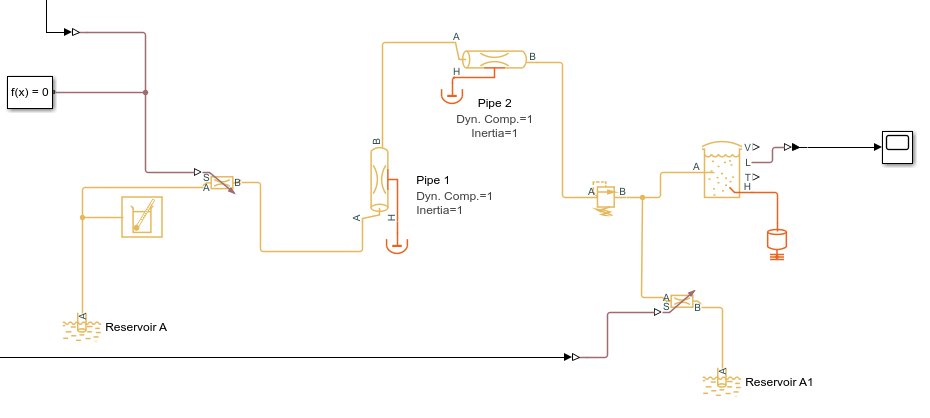

In [2]:
img = cv2.imread("/content/drive/MyDrive/IA/Proyecto/Modelo.PNG")
cv2_imshow( img)

**Explicacion del funcionamiento**
Pensando en los datos que se podrian tomar cuando se realice el montaje fisico, se planteo lo siguiente.

El ciclo de trabajo de la bomba funciona se establece en intervalos de 4 horas, en el modelo reducido("**SubPlanta**") se tomo como 4 segundos. 

El estimulo del sistema es el ciclo de trabajo(10%-88%) de la bomba dentro de esas 4 Horas. La salida del sistema es la altura del tanque a lo largo del tiempo.


**Simulacion**
Se simularan las siguientes condiciones de la "**SubPlanta**" 

Se tomaran datos de la altura de la planta en 20-25 segundos, para cada uno de los siguientes ciclos de trabajo en la bomba: (10%,14%,20%,25%,30%,35%,42%,45%,54%,***57%***,62%,65%,70%,75%,88%)

A continuacion una grafica de la simulcion corresondiente a 1 ciclo de trabajo de 88%

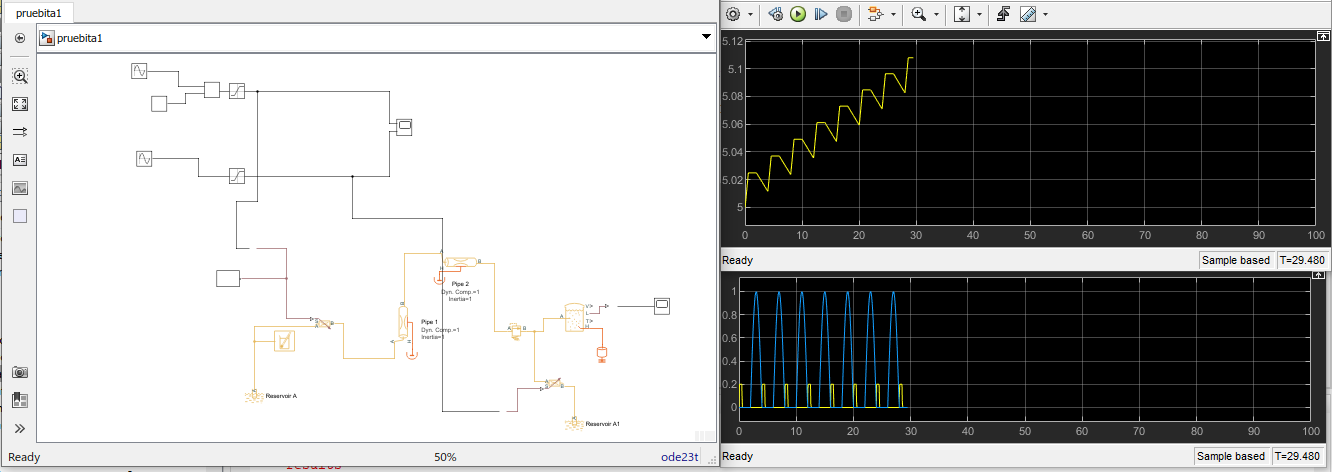

In [3]:
img = cv2.imread("/content/drive/MyDrive/IA/Proyecto/Simulacion.PNG")
cv2_imshow( img)


**Muestreo**
El muestreo de los datos se hara en periodos de 4 segundos(al final de cada ciclo de trabajo para la bomba).



A continuacion una grafica del proceso de muestreo realizado en Matlab

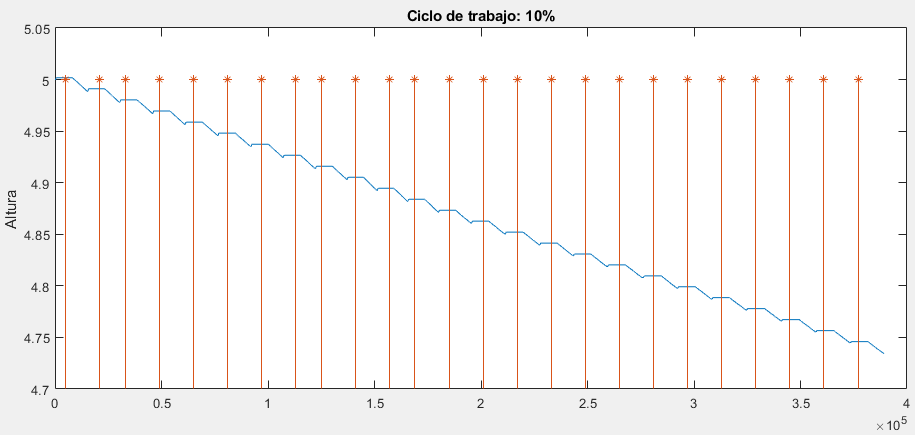

In [4]:

img = cv2.imread("/content/drive/MyDrive/IA/Proyecto/Grafiquito.PNG")
cv2_imshow( img)


**Descripcion de los datos**
Se tienen 15 series de tiempo(para diferentes condiciones de ciclo de trabajo) con 20-25 datos cada una que corresponden a la altura del tanque a lo largo de cada ciclo de trabajo.

Nota: No se simuaron mas datos, por que llevandolo a la escala del problema real, con los ciclos de trabajo definidos en 4 horas pues , se necesitarian 2 meses aproximadamente para tomar esa cantidad de datos. (no tiene sentido que el periodo de muestreo sea mucho menor, por que las interacciones quimicas de ph,amoniaco,oxigeno disuelto, son muy lentas)


*A continuacion una vista de los datos inciales*

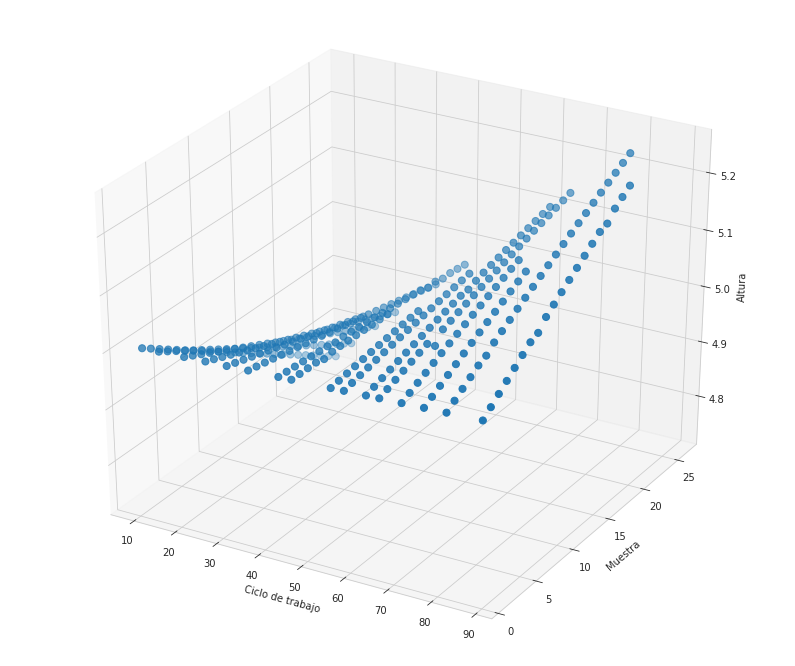

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/IA/Proyecto/DatosRaw.csv",header=None, sep=',')
df.head()
#print(df[0].values)
sb.set_style("whitegrid")
plt.figure(figsize=(14,12))
axes = plt.axes(projection='3d')

axes.scatter3D(df[0].values,df[1].values, df[2].values,sizes=[50,50])
axes.view_init(elev=20, azim=-70)
axes.set_xlabel('Ciclo de trabajo')
axes.set_ylabel('Muestra')
axes.set_zlabel('Altura')

axes.view_init(30, -60)
plt.show()


## Descripcion de las tecnicas a usar

**Limpieza**

Como se va a usar una ANN por series de tiempo, la cual tiene las siguientes entradas y salidas:

Entradas:  X=[H,Ha,C]
*   H:Altura
*   Ha:Altura Anterior
*   C: Ciclo De Trabajo que se le va a aplicar a la "**SubPlanta**"

SALIDAS:
*   Hs: Altura siguiente del tanque



**Validacion**

Se hara una evaluacion con el 5% de los datos
y el 95% restante se usara para entrenar el modelo usando 5 pliegues con Cross Validation.



## DESARROLLO

**Limpieza**

Lo unico que hay que hacer, es convertir los datos a las correspondientes entradas x,y  para la red neuronal, descrita anteriormente. Este proceso se hizo en matlab, con lo cual tendriamos los siguientes datos:

In [ ]:
DataSet=pd.read_csv("/content/drive/MyDrive/IA/Proyecto/DatosLimpios.csv",header=None, sep=',')
DataSet.columns=['H','Ha','C','Hs']
DataSet.head()

,H,Ha,C,Hs
0,4.9911,5.0018,10,4.9803
1,4.9803,4.9911,10,4.9695
2,4.9695,4.9803,10,4.9588
3,4.9588,4.9695,10,4.9481
4,4.9481,4.9588,10,4.9374


**Evaluacion**

Como se menciono en el apartado anterior, se usara el 5% para evaluacion y con el 95% se hara cross-Validation con 5 particiones.

Pero ademas de esto, no se entrenara ni evaluara con los datos correspondientes al ciclo de trabajo de 57%, para poder realizar una ultima validacion la capacidad de prediccion(cuantos en el futuro?) de la red. Pues se espera que la red sea usada para una tecnica de control predictivo



In [ ]:

DataSetF=DataSet.drop(DataSet[DataSet['C']== 57].index)
#print(DataSet[DataSet['C']== 57])
dfX=DataSetF[['H','Ha','C']]
dfY=DataSetF[['Hs']]


In [ ]:

dfXTrain,dfX_Evaluation,dfYTrain,dfY_Evaluation = train_test_split(dfX,dfY,test_size=0.05)

**Normalizacion**

In [ ]:
Data=np.array(dfXTrain.values)
scaler = StandardScaler()
scaler.fit(Data)
MeanTrain=scaler.mean_
VarTrain=scaler.var_
dfXTrainNorm=scaler.transform(Data)

**Analisis de dimensionalidad**

In [ ]:
pca = decomposition.PCA(n_components=3)


#The optional parameter whiten=True makes it possible to project the data onto the singular space while scaling each component to unit variance.
pca.fit(dfXTrainNorm)
#X = pca.transform(X)
vars=pca.explained_variance_ratio_
print("Pesos de PCA:",vars*100/sum(vars))

Pesos de PCA: [9.47415822e+01 5.25323965e+00 5.17816787e-03]


Si tomamos 2 dimensiones, estariamos obteniendo el 99.99% de la varianza.
Con lo cual se llega a la conclusion de que es ulti reducir la dimensionalidad.

In [ ]:
pca = decomposition.PCA(n_components=2)
pca.fit(dfXTrainNorm)
EigenValues=pca.explained_variance_ratio_
EigenVectors=np.transpose(np.array(pca.components_))

dfXTrainNorm2Dim = pca.transform(dfXTrainNorm)


**Creacion y entrenamiento del modelo (con grid search)**

A continuacion se entrenan los diferentes modelos de acuerdo a las siguientes caracteristicas.

Fijas: 


*   solver: se usa 'lbfgs' pues es el mas adecuado para dataset pequeños
*   activation: se usa 'identity' pues se necesita calcular los datos de una serie de tiempo con numeros de distintos rangos que ademas visto de otra forma esta modelando la respuesta de un sistema fisico.(se habia probado tambien con relu, pero la diferencia entre los reslutados era demasiada en comparacion a identity)

Grid Search:


*   hidden_layer_sizes: se iteraton distintas cantidades de capas y neuronas para la red

  *   2 capas: 10 y 20 neuronas por capa
  *   3 capas: 5, 10, 20 y 30 neuronas por capa
  *   4 capas: 10, 20 y 30 neuronas por capa
  *   5 capas: 10 neuronas por capa

*   alpha: se hicieron variaciones sobre el parámetro de regularización 'alfa', pues en un principio estaba dando resultados muy poco exactos, entonces era necesario fomentar los pesos mas grandes.








In [ ]:
from sklearn.neural_network import MLPRegressor
verbose=False
clf = MLPRegressor(random_state=1 ,verbose=verbose,solver='lbfgs',activation='identity',max_iter=300)
#parameters = {'activation':('identity', 'logistic', 'relu', 'softmax', 'tanh'),'hidden_layer_sizes': [(30,50,30)],'max_iter':[500]}
parameters = {'hidden_layer_sizes': [(10,10),(20,20),(5,5,5),(10,10,10),(20,20,20),(30,30,30),(10,10,10,10),(20,20,20,20),(30,30,30,30),(10,10,10,10,10)],'alpha':[0.0001,0.0005,0.0010]}
#print(dfYTrain.values.flatten())
clf_grid = GridSearchCV(clf, parameters)
clf_grid.fit(dfXTrainNorm2Dim, dfYTrain.values.flatten());

In [ ]:
data=clf_grid.cv_results_
dfit = pd.DataFrame(data)

A continuacion se realiza el top rank 15, de los resultados

In [ ]:

dfit.loc[(dfit['rank_test_score']<=15),['rank_test_score','param_hidden_layer_sizes', 'param_alpha','mean_fit_time', 'mean_score_time', 'mean_test_score','std_test_score','std_score_time','params']]

,rank_test_score,param_hidden_layer_sizes,param_alpha,mean_fit_time,mean_score_time,mean_test_score,std_test_score,std_score_time,params
3,9,"(10, 10, 10)",0.0001,0.007905,0.000764,0.999766,0.000240,0.000169,"{'alpha': 0.0001, 'hidden_layer_sizes': (10, 1..."
6,15,"(10, 10, 10, 10)",0.0001,0.006210,0.000544,0.999766,0.000241,0.000019,"{'alpha': 0.0001, 'hidden_layer_sizes': (10, 1..."
7,12,"(20, 20, 20, 20)",0.0001,0.011902,0.000812,0.999766,0.000240,0.000194,"{'alpha': 0.0001, 'hidden_layer_sizes': (20, 2..."
8,1,"(30, 30, 30, 30)",0.0001,0.014460,0.000866,0.999767,0.000240,0.000289,"{'alpha': 0.0001, 'hidden_layer_sizes': (30, 3..."
9,6,"(10, 10, 10, 10, 10)",0.0001,0.011014,0.000918,0.999766,0.000239,0.000313,"{'alpha': 0.0001, 'hidden_layer_sizes': (10, 1..."
13,8,"(10, 10, 10)",0.0005,0.006005,0.000539,0.999766,0.000240,0.000040,"{'alpha': 0.0005, 'hidden_layer_sizes': (10, 1..."
16,14,"(10, 10, 10, 10)",0.0005,0.006115,0.000520,0.999766,0.000241,0.000029,"{'alpha': 0.0005, 'hidden_layer_sizes': (10, 1..."
17,11,"(20, 20, 20, 20)",0.0005,0.010194,0.000683,0.999766,0.000240,0.000166,"{'alpha': 0.0005, 'hidden_layer_sizes': (20, 2..."
18,2,"(30, 30, 30, 30)",0.0005,0.012307,0.000661,0.999767,0.000240,0.000021,"{'alpha': 0.0005, 'hidden_layer_sizes': (30, 3..."
19,5,"(10, 10, 10, 10, 10)",0.0005,0.009575,0.000708,0.999766,0.000239,0.000155,"{'alpha': 0.0005, 'hidden_layer_sizes': (10, 1..."


Se encontro que el mejor resultado en terminos de score, es el modelo con 4 capas de a 30 neuronas cada una, con un coeficiente de regularizacion igual a 0,001. Ademas este resultado, posee uno de los tiempos de entrenamiento mas pequeños

**Re-entrenamiento**

In [ ]:
Parametros=dfit.loc[ 8,'params']
print(Parametros)
clf = MLPRegressor(**Parametros,random_state=1 ,verbose=verbose,solver='lbfgs',activation='identity',max_iter=300)
clf.fit(dfXTrainNorm2Dim, dfYTrain.values.flatten())
clf.score(dfXTrainNorm2Dim, dfYTrain.values.flatten())

{'alpha': 0.0001, 'hidden_layer_sizes': (30, 30, 30, 30)}


0.9997866700048459

**Evaluacion**

R2= 0.9998876579630378


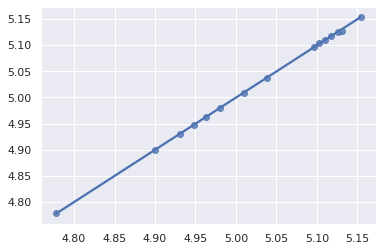

In [ ]:
from seaborn import regplot
sb.set_theme(color_codes=True)
#https://seaborn.pydata.org/generated/seaborn.regplot.html

Data2=np.array(dfX_Evaluation.values)
dfX_Evaluation_Norm=scaler.transform(Data2)
DfX_Evaluation_Norm2Dim = pca.transform(dfX_Evaluation_Norm)


y_pred_test_nn =clf.predict(DfX_Evaluation_Norm2Dim)
R2=clf.score(DfX_Evaluation_Norm2Dim, dfY_Evaluation.values.flatten())
print("R2=",R2)

ax = regplot(x=dfY_Evaluation.values.flatten() ,y=y_pred_test_nn, color="b")


**Prediccion continua**

Como se menciono anteriormente, se necesita realizar una evaluacion de la capacidad predictiva de la red(hasta cuantos pasos adelante puede permitir partiendo de un mismo estado inicial en la "**SubPlanta**" )

In [ ]:
#Ciclo=57


def function_Serie_Prediction(Ciclo):
  DataSetN=DataSet.loc[DataSet['C']== Ciclo,['H','Ha','C','Hs']]
  #print(DataSetF.values)
  #print(DataSet[DataSet['C']== 57])



  SerieHReal=np.append(np.array(DataSetN[['H']].values),DataSetN['Hs'].iloc[-1])

  SeriePredicha=np.array(DataSetN['H'].iloc[0])
  ValActual=DataSetN['H'].iloc[0]
  ValAnterior=DataSetN['Ha'].iloc[0]


  for i in range(0,DataSetN.shape[0]):
    X=np.array([[ValActual,ValAnterior,Ciclo]])
    X_Norm=scaler.transform(X)
    X_Norm2Dim = pca.transform(X_Norm)
    Predict =clf.predict(X_Norm2Dim)
    ValAnterior=ValActual
    ValActual= Predict[0]
    SeriePredicha=np.append(SeriePredicha,ValActual)
  return SerieHReal,SeriePredicha


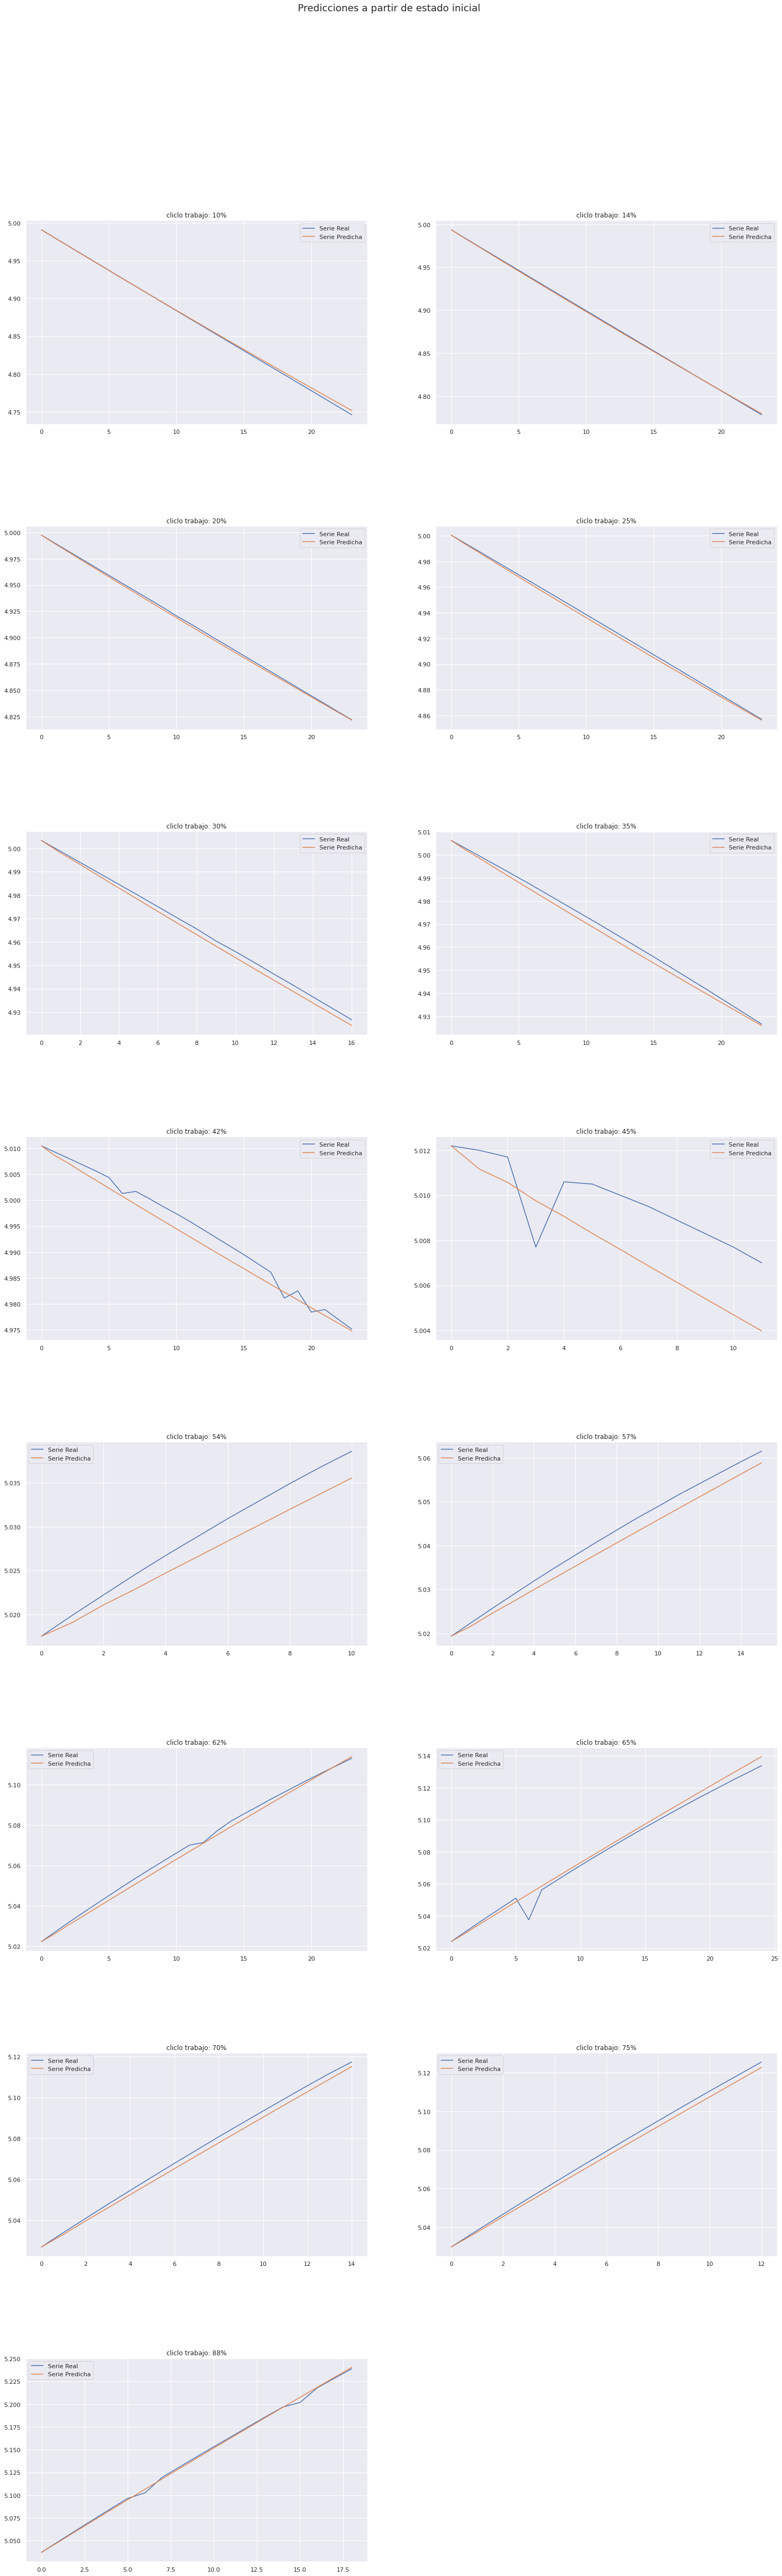

In [ ]:
plt.figure(figsize=(25, 80))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Predicciones a partir de estado inicial", fontsize=18, y=0.95)

valuesG=[10,14,20,25,30,35,42,45,54,57,62,65,70,75,88]

# loop through the length of tickers and keep track of index
for n,val in enumerate(valuesG):
    # add a new subplot iteratively
    ax = plt.subplot(8, 2, n+1)
    # filter df and plot ticker on the new subplot axis
    # chart formatting
    

    YR,YP=function_Serie_Prediction(val)
    ax.set_title("cliclo trabajo: "+str(val)+"%")
    ax.plot(YR)
    ax.plot(YP)
    ax.legend(['Serie Real', 'Serie Predicha']);
    ax.set_xlabel("")



Con lo anterior, podemos ver que en la mayoria de las predicciones, despues de la 3 prediccion en serie, empieza a diverger la Serie predicha, del Comportamiento real del sistema.